In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Union
from statsmodels.tsa.seasonal import seasonal_decompose, STL


# Moving Average

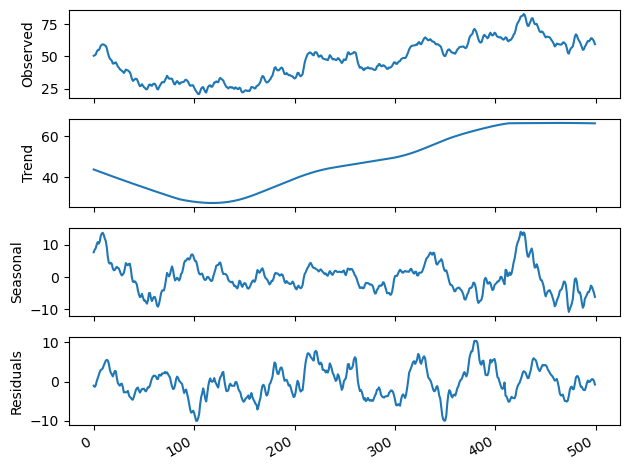

In [83]:
advanced_decomposition = STL(df.widget_sales, period=90).fit()
# noinspection PyTypeChecker
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


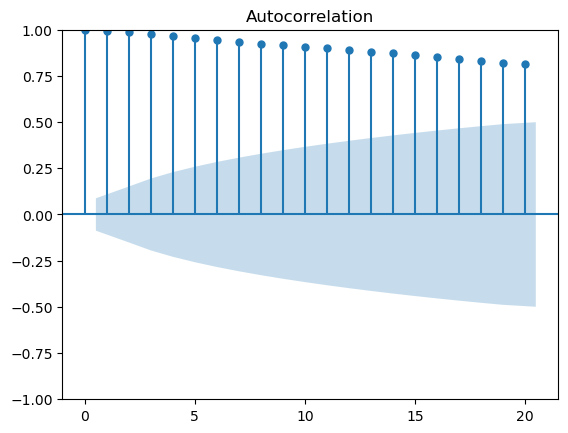

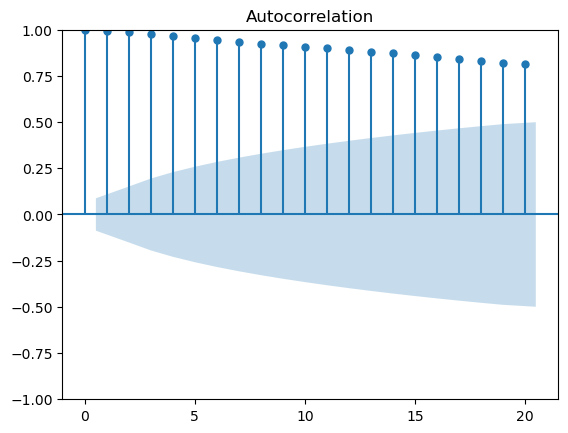

In [84]:
ADF_result = adfuller(df['widget_sales'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
plot_acf(df['widget_sales'], lags=20)


ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


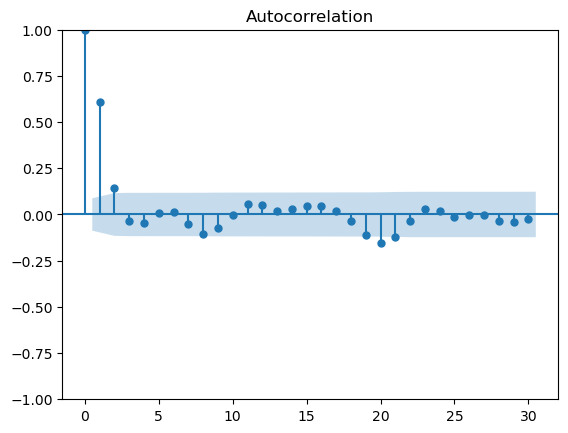

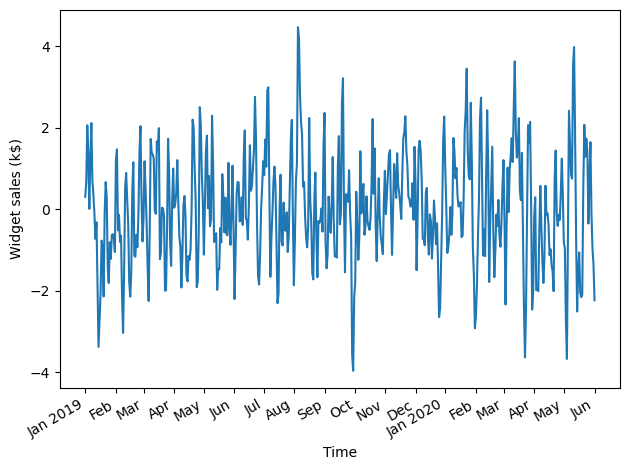

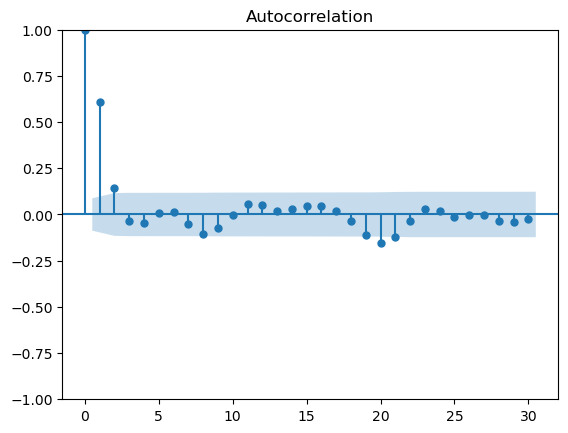

In [85]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
ADF_result = adfuller(widget_sales_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
plot_acf(widget_sales_diff, lags=30)
#plot_pacf(widget_sales_diff, lags=30)

Things become interesting, this time we have not only point 0 but also 1 and 2 that are significant. We can use moving average of order 2 

The moving average order q in time series models represents the number of past forecast errors that are used to predict future values. It's an essential part of models that aim to smooth out random fluctuations and forecast future values in a time series.



The order \( q \) in the Moving Average (MA) part of time series models like ARMA and ARIMA represents the number of lagged forecast errors used in the model. Specifically:

- **Moving Average (MA) Part**: This component of the model accounts for the time series being influenced by past error terms. These errors are the discrepancies between past actual values and their predicted values from the model.

- **Defining Order \( q \) in MA**: 
  - In an MA(1) model, one lagged forecast error is used, which can be represented as: 
    $X_t = μ + ε_t + θ_1ε_{t-1}$
  - An MA(2) model includes two lagged errors, represented as: 
    $X_t = μ + ε_t + θ_1ε_{t-1} + θ_2ε_{t-2}$
  - Here, `μ` is the mean of the series, $ε_t$ are the white noise error terms, and `θ` are the parameters of the model.



let's start the process by splitting the dataset 

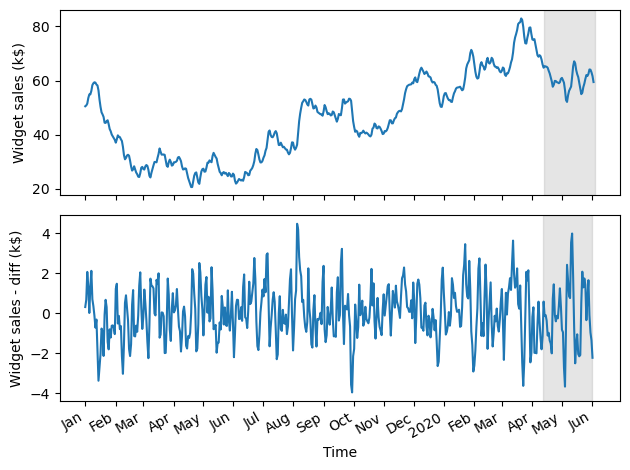

In [86]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

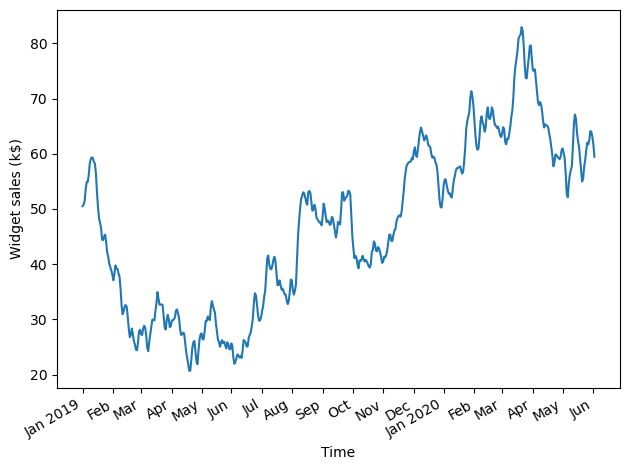

In [82]:
df = pd.read_csv('../data/widget_sales.csv')
df.head()
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

Now let's create our prediction models, the rolling forecast works in the following way :
we use  the train set to predict the future two values 0 and 1, then we use the train set and the 2 values of original data (not the predicted 0 and 1 at previous iteration) to predict 2 and 3, etc. until we reach the prediction of the last two values. 
Now we consider three models:
- mean: predict the arithmetic average on the train+extension data set to produce predictions 
- last: copy the last values
- MA: retrain the SARIMAX model to fit the extended dataset each step and predict new values
 

In [87]:
def rolling_forecast(_df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        _pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(_df[:i].values)
            _pred_mean.extend(mean for _ in range(window))

        return _pred_mean

    elif method == 'last':
        _pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = _df[:i].iloc[-1].values[0]
            _pred_last_value.extend(last_value for _ in range(window))
            
        return _pred_last_value
    
    elif method == 'MA':
        _pred_MA = []
        
        for i in range(train_len, total_len, window):
            _model = SARIMAX(_df[:i], order=(0,0,2))
            res = _model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            _pred_MA.extend(oos_pred)
            
        return _pred_MA

copy the test set to avoid modifying the original, the window is two since we use moving average of order 2. Then plot results 

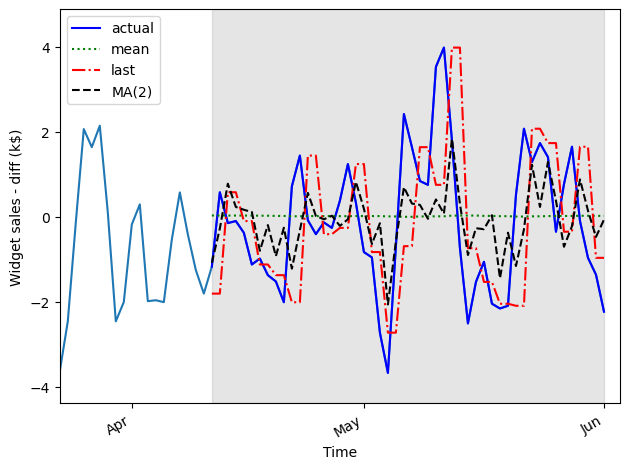

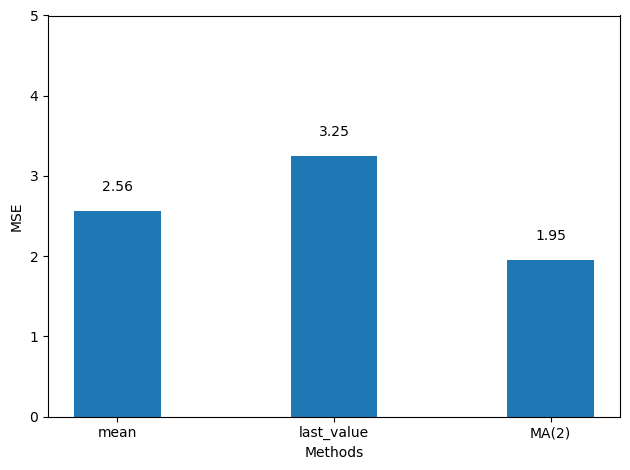

In [88]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean       = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA         = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA


mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])




fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()


Now we have MA as our best predictor, but remember it is on the differentiated serie.
We need to predict on the original serie : 
since the original serie was a0 , a1, a2 etc.
the differentiated serie was b1=a1-a0, b2=a2-a1 ... 
we predicted bs for b450->b500, and we want a450->a500
sum over bs until any k>450 (with cumsum) and 
Sum(bi[0->k])= ak-a0=ak-a450+a450-a0= ak-a450+Sum(bi[0->450]).
Since bi[0->450] have not been computed it can be considered 0 
so Sum(bi[0->k])= ak-a450 therefore ak=Sum(bi[0->k])+a450 


/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/440953154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum() # for predicted values on diff., reverse transformation with cumsum


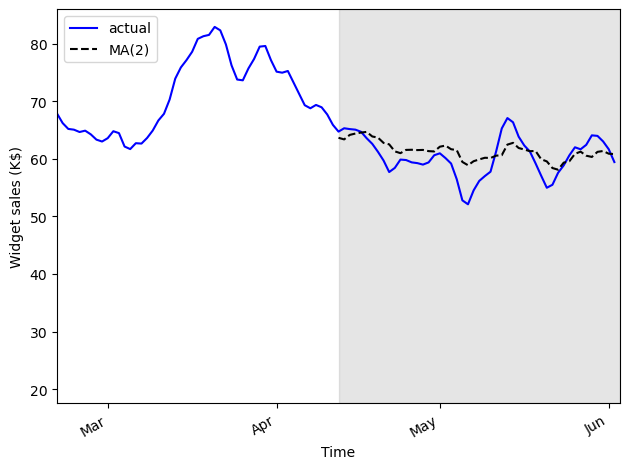

In [89]:
df['pred_widget_sales'] = pd.Series() # initialize an empty column
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum() # for predicted values on diff., reverse transformation with cumsum




fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()


### Comparison of Mean Squared Error and Mean Absolute Error

`mean_squared_error` and `mean_absolute_error` are two metrics from the `sklearn.metrics` module used for evaluating regression models. Below is a detailed comparison:

#### Mean Squared Error (MSE)
- **Formula**: `MSE = (1/n) * Σ(yi - ŷi)²`
- **Explanation**: MSE calculates the average of the squares of the errors, where errors are the differences between the predicted values (ŷi) and the actual values (yi).
- **Characteristics**:
  - Sensitive to large errors due to squaring of the errors.
  - The units are squared units of the output variable, making it less intuitive.
  - More suitable when large errors are particularly undesirable.

#### Mean Absolute Error (MAE)
- **Formula**: `MAE = (1/n) * Σ|yi - ŷi|`
- **Explanation**: MAE calculates the average of the absolute values of the errors, measuring the average magnitude of errors in predictions.
- **Characteristics**:
  - Less sensitive to outliers compared to MSE.
  - The units are the same as those of the output variable, making it more interpretable.
  - Preferable when you require a more direct measure of error magnitude.

#### Choosing Between MSE and MAE
- **Outliers**: Choose MAE if your data contains many outliers or if minimizing the influence of outliers is important.
- **Error Interpretation**: If having the error metric in the same units as the data is important, MAE is preferable.
- **Emphasizing Larger Errors**: If larger errors are more problematic and should be emphasized, MSE might be the better choice.

The choice between MSE and MAE largely depends on the specific context of your problem and the nature of your dataset.


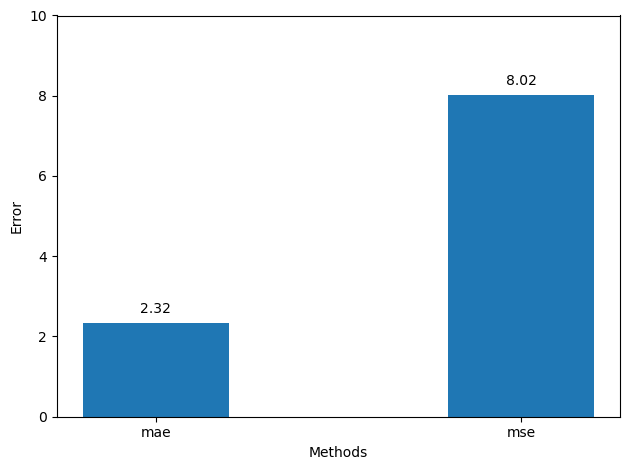

In [90]:
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
mse_MA_undiff = mean_squared_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])


fig, ax = plt.subplots()

x = ['mae', 'mse']
y = [mae_MA_undiff, mse_MA_undiff]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('Error')
ax.set_ylim(0, 10)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()


# AutoRegressive

What happens if MA 

New dataset to illustrate auto regressive

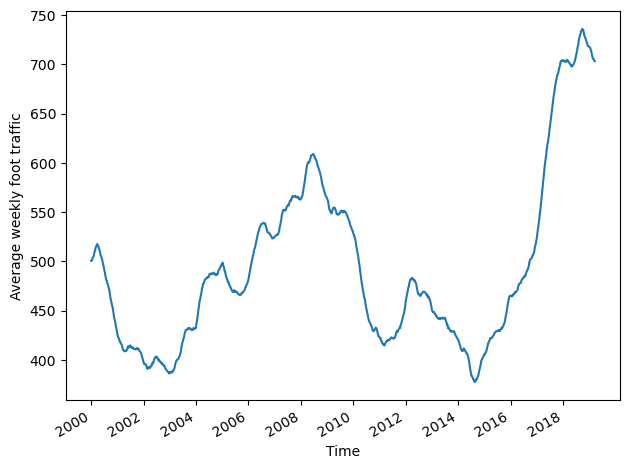

In [91]:
df = pd.read_csv('../data/foot_traffic.csv')
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


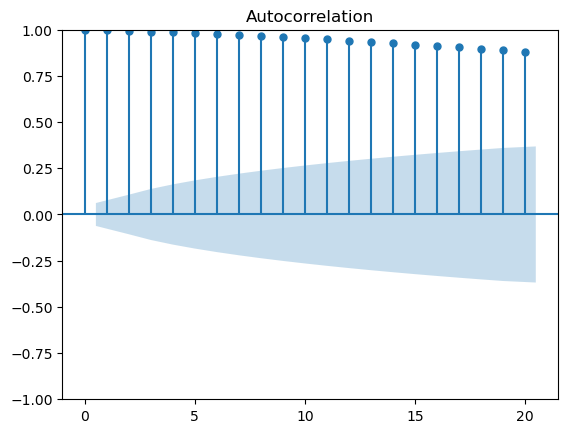

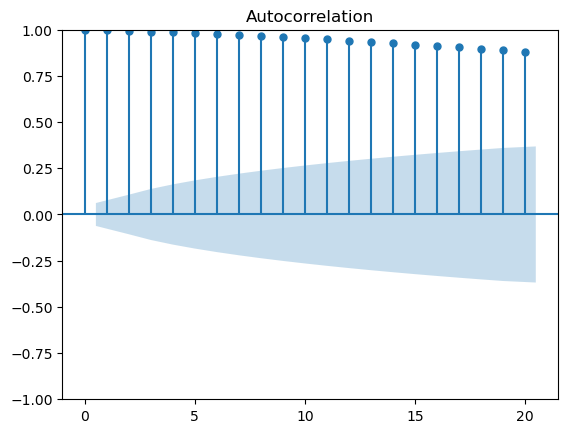

In [92]:
ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
plot_acf(df['foot_traffic'],lags=20)

we can see ADF is inconclusive and ACF doesn't show a drop, let's check with diff

ADF Statistic: -5.268231347422044
p-value: 6.369317654781239e-06


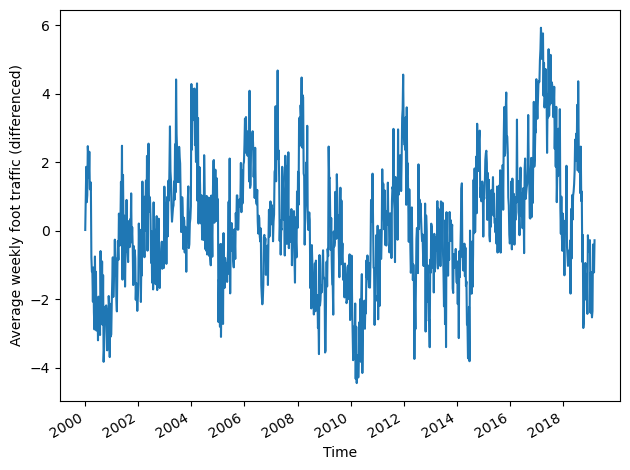

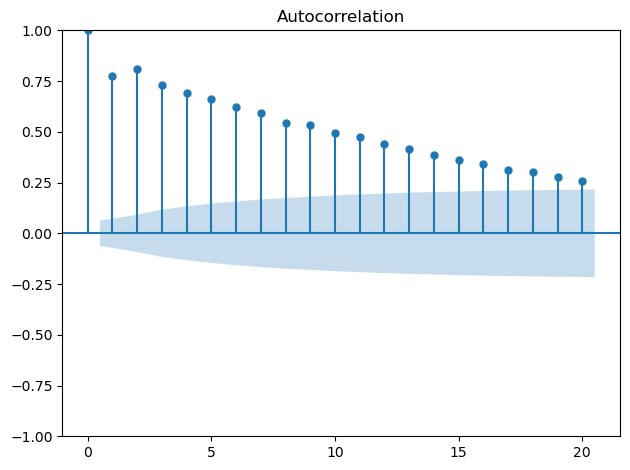

In [93]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()
ADF_result = adfuller(foot_traffic_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
plot_acf(foot_traffic_diff, lags=20);

plt.tight_layout()

ADF rejects null hypothesis (there is correlation), but the drop is not brutal so not a moving average. When that happens, it can be because partial coefficients are taken into account, so we can compensate using pacf

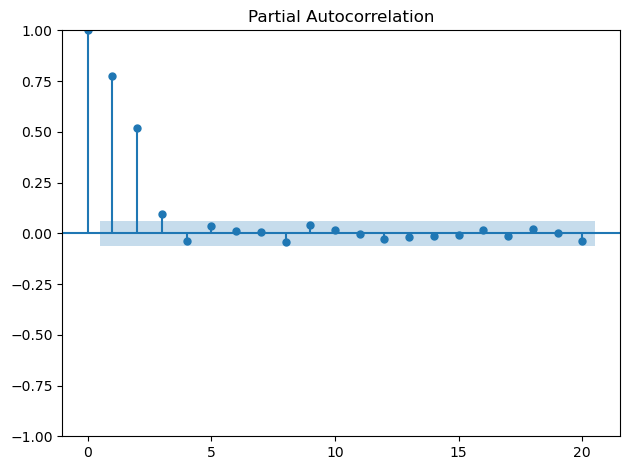

In [94]:
plot_pacf(foot_traffic_diff, lags=20)

plt.tight_layout()

Since it drops, we are in an autoregressive process (order 3, since three coefficients are outside the confidence interval). Let's create a train-test datasets
test is the last year, and it is in weeks so 52 points 

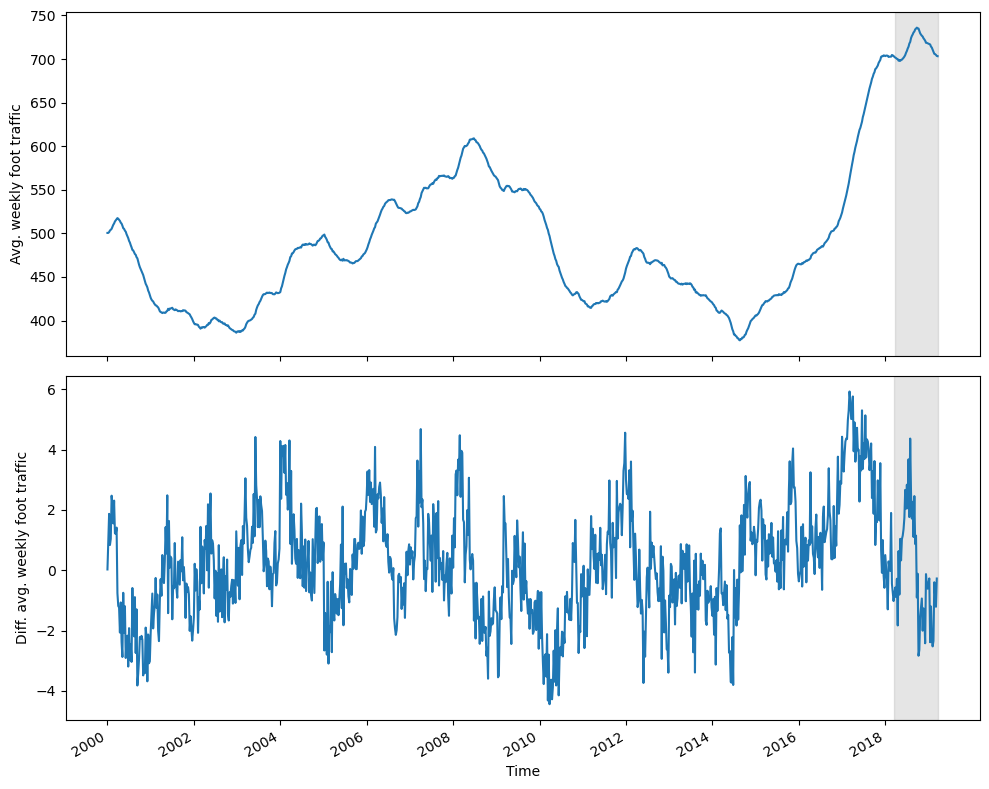

In [95]:
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
train = df_diff[:-52]
test = df_diff[-52:]
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

let's define predictions again, but we have a sarimax different for the AR(3)

In [96]:
def rolling_forecast2(_df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        _pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(_df[:i].values)
            _pred_mean.extend(mean for _ in range(window))
            
        return _pred_mean

    elif method == 'last':
        _pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = _df[:i].iloc[-1].values[0]
            _pred_last_value.extend(last_value for _ in range(window))
            
        return _pred_last_value
    
    elif method == 'AR':
        _pred_AR = []
        
        for i in range(train_len, total_len, window):
            _model = SARIMAX(_df[:i], order=(3,0,0))
            res = _model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            _pred_AR.extend(oos_pred)
            
        return _pred_AR

/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/3487855262.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_mean'] = pred_mean
/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/3487855262.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_last_value'] = pred_last_value
/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/3487855262.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

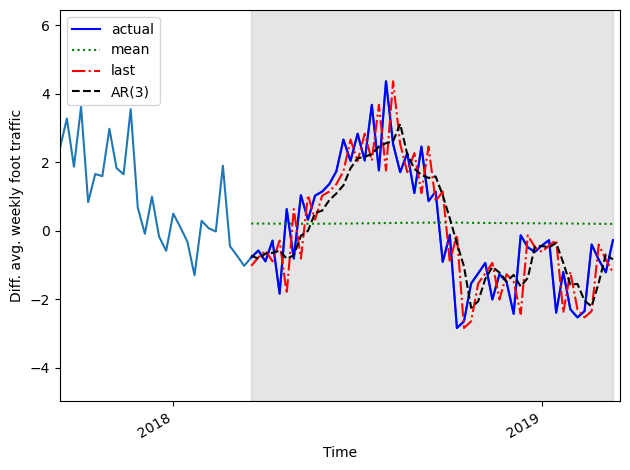

In [97]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean       = rolling_forecast2(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast2(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_AR         = rolling_forecast2(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
test['pred_AR'] = pred_AR

fig, ax = plt.subplots()

ax.plot(df_diff['foot_traffic_diff'])
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_AR'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

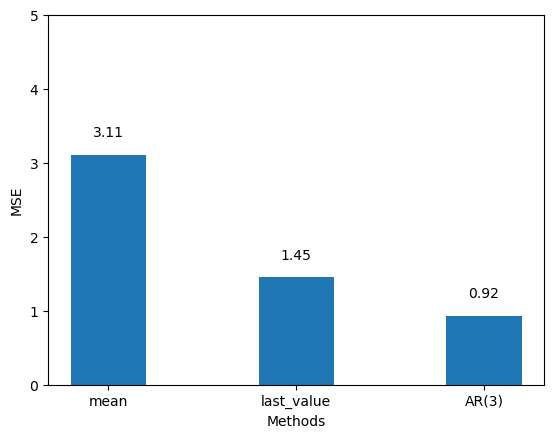

In [98]:
mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'AR(3)']
y = [mse_mean, mse_last, mse_AR]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/2875150940.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()


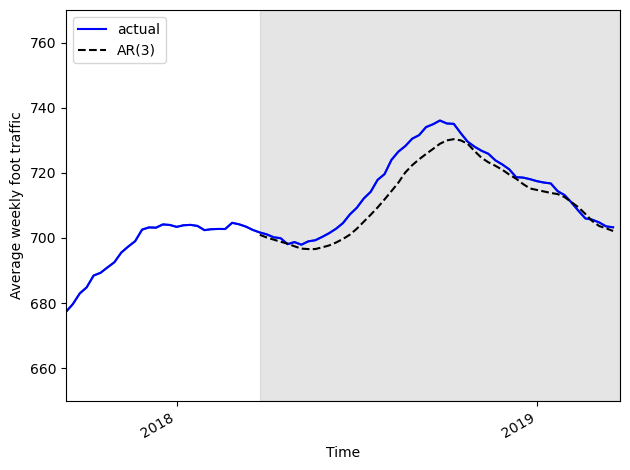

In [99]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[948] + test['pred_AR'].cumsum()

fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()



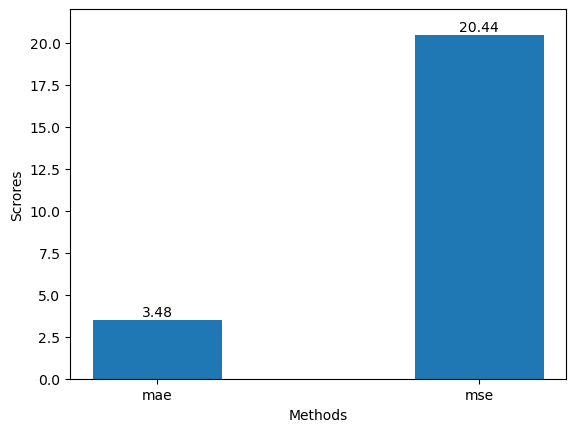

In [100]:
mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])
mse_AR_undiff = mean_squared_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

fig, ax = plt.subplots()

x = ['mae', 'mse']
y = [mae_AR_undiff, mse_AR_undiff]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('Scores')
ax.set_ylim(0, 22)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

# Last scenario : autoregressive moving average

what happens if both acf and pacf plots are decaying slowly?  
lets first study that on a synthetic dataset created just for the sake of observation
where $y_{t}=0.33 y_{t-1} + 0.9 \epsilon_{t-1} + \epsilon_{t}$
 

In [101]:
np.random.seed(42)

ar1 = np.array([1, -0.33]) #documentation ask to always put 1 as the first element 
ma1 = np.array([1, 0.9]) #documentation ask to always put 1 as the first element 

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

no surprise since created on purpose, but it is stationary 

ADF Statistic: -6.429878682042711
p-value: 1.7078466680095014e-08


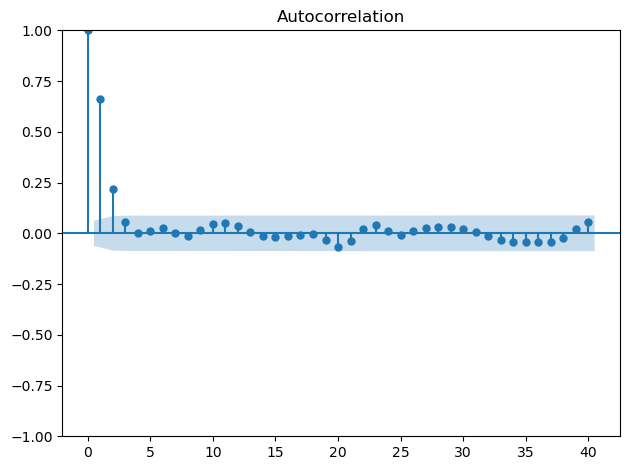

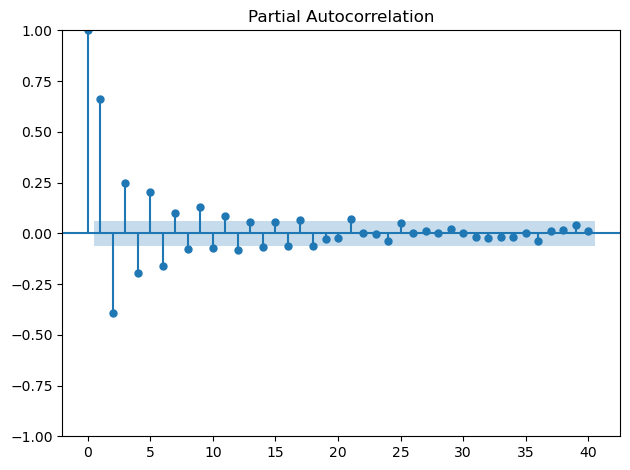

In [102]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

plot_acf(ARMA_1_1, lags=40)
plt.tight_layout()

plot_pacf(ARMA_1_1, lags=40)
plt.tight_layout()

In both cases, you can see a sinusoidal pattern. It means we do not have AR or MA, but ARMA(p,q) process
determining p and q is key: we cannot rely on the plots since they are both sinusoidal/decaying 

let's say we have p,q<4 we first create every combination 

In [103]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

We will use AIC to check for every pair a score, to select the best combination
AIC (Aikake Information Criterion) is giving a score to assess the quality of the predictive model, 
$$AIC=2k-2ln(L)$$
where k is the number of parameters (here $k=p+q$) and $L$ is the  
likelihood is a probability to observe the set of data given a particular model.
when comparing models, the lowest AIC is the best:
the more k is high the more we might overfit (and L is naturally high), and the more AIC is big 
Logic is that we want the best L with lowest k!


Let's create a function that for a time serie (endogenous variable) we check every (p,q) to find the best model

In [104]:
def optimize_ARMA(endogenous: Union[pd.Series, list], _order_list: list) -> pd.DataFrame:
    
    results = []
    
    #when using tqdm_notebook(order_list) instead of order_list, we have a progress bar 
    for order in tqdm_notebook(_order_list):
        # noinspection PyBroadException
        try: 
            #p=order[0] and q=order[1]
            _model = SARIMAX(endogenous, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = _model.aic
        results.append([order, aic])
        
    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df_local = result_df_local.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_local

In [105]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/2260433852.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/Users/mickaelwajnberg/.conda/envs/time_series/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mickaelwajnberg/.conda/envs/time_series/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mickaelwajnberg/.conda/envs/time_series/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.156195
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


no surprise here: 1,1 is our best model 

now that we have our best model among the list, we need to evaluate if it is a good prediction model. 
At the beginning of the section we defined $$y_{t}=0.33 y_{t-1} + 0.9 \epsilon_{t-1} + \epsilon_{t}$$
Now we have fit a model as the ARMA(1,1) and if the fit is good we should have found that $$\hat{y_{t}}=0.33 y_{t-1} + 0.9 \epsilon_{t-1}$$
therefore $$y_{t} - \hat{y_{t}}=\epsilon_{t}$$ which equals to a random white noise (this difference is also called residuals)

We need to test if that is effectively white noise. We compare the distribution of white noise to the distribution of the difference with a Q-Q plot
if a distribution is on the line it means it is a gaussian white noise. If not, it is another distribution. For instance, with the other distribution gamma, it won't fall on the line.

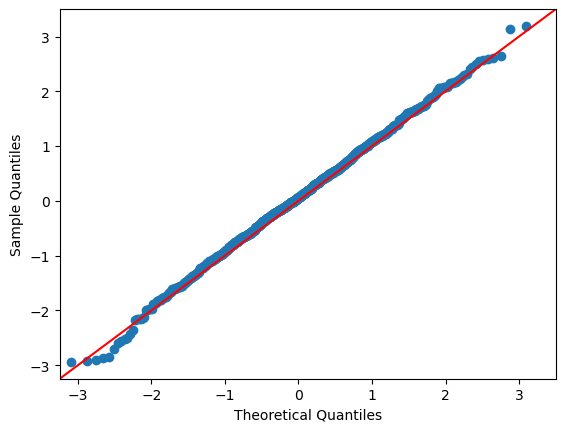

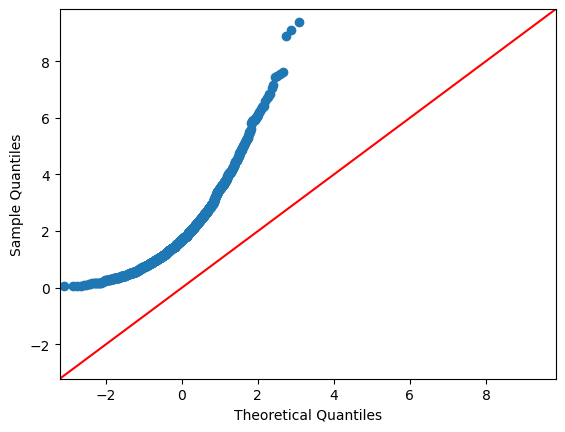

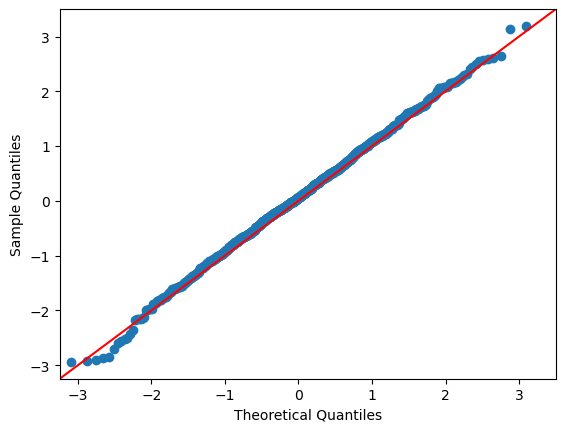

In [106]:
gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)
qqplot(gamma, line='45')
normal = np.random.normal(size=1000)
qqplot(normal, line='45')

let's test on our model: it will per construction be gaussian 

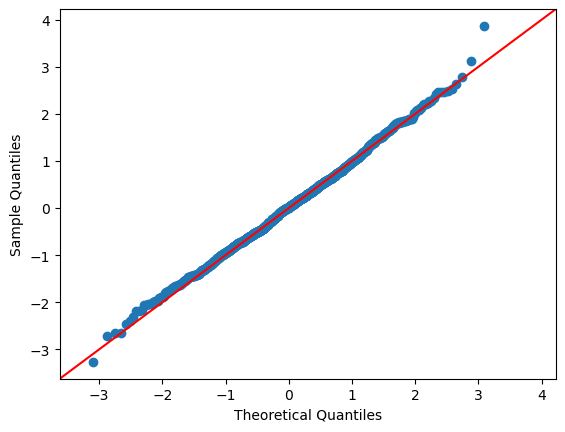

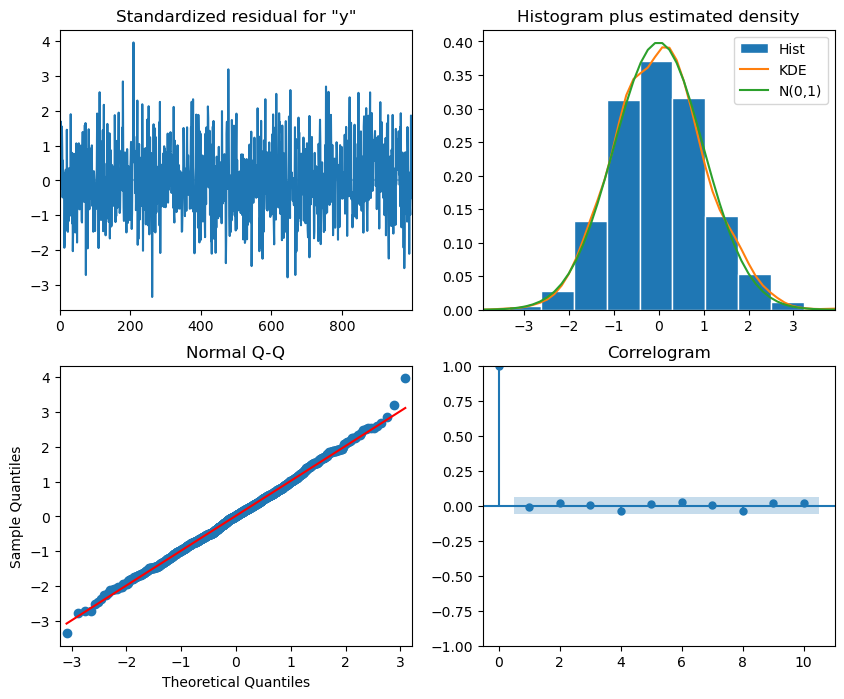

In [107]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid
qqplot(residuals, line='45');


While you cannot definitively prove a series is white Gaussian noise, you can gather evidence through a variety of tests and analyses to support the hypothesis. A combination of auto-correlation checks, normality tests, and examination of statistical properties can provide a strong indication that a series approximates white Gaussian noise.

we test for stationarity (validated) 

In [108]:
res2= residuals.copy()
adf_res = adfuller(res2)
print("ADF Test Statistic:", adf_res[0])
print("p-value:", adf_res[1])


ADF Test Statistic: -31.74995842605871
p-value: 0.0


and for non-correlation 

In [113]:
ljung_box_result = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(ljung_box_result)

     lb_stat  lb_pvalue
1   0.030706   0.860897
2   0.528021   0.767966
3   0.540904   0.909817
4   2.079774   0.721089
5   2.271897   0.810385
6   2.896262   0.821750
7   2.900378   0.894063
8   4.418799   0.817501
9   4.787567   0.852419
10  5.246805   0.874093


H0 is not rejected, and the null hypothesis for the Ljung-Box test states that the data are independently distributed. This doesn't prove it is independently distributed, but that's a hint.
Plot diagnostics helps in multiple hints: observe white noise, check if distribution is gaussian, and observe no correlation (hinted by the ljung-box test)

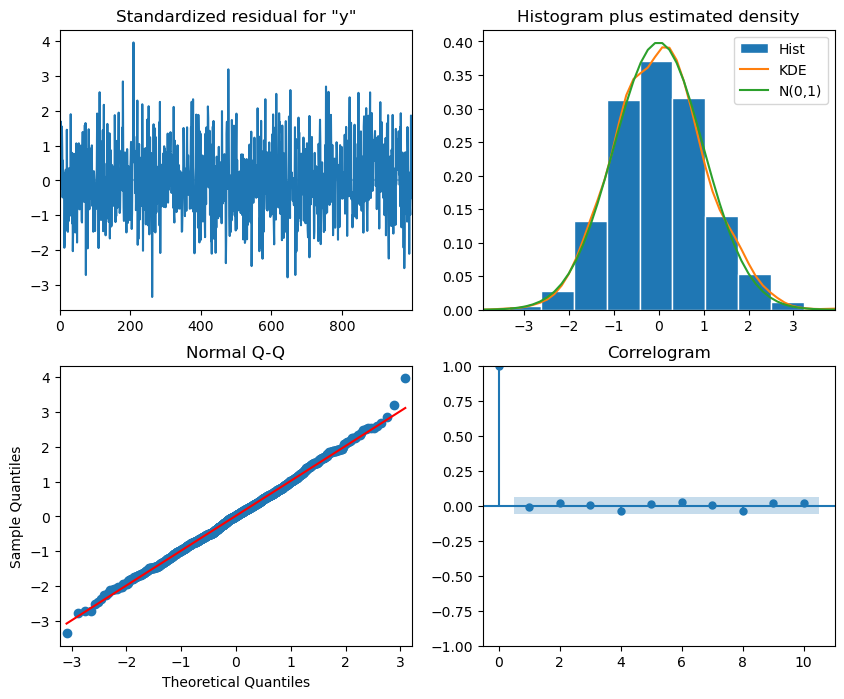

In [114]:
model_fit.plot_diagnostics(figsize=(10, 8));

let's do the same on a real dataset of bandwidth allocation 

ADF Statistic: -0.8714653199452412
p-value: 0.7972240255014654


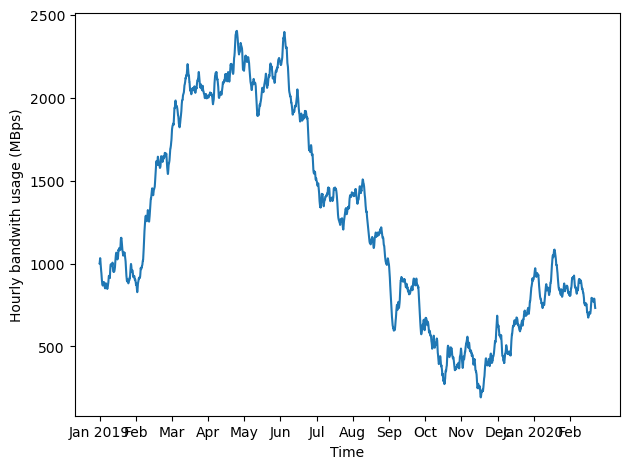

In [118]:
df = pd.read_csv('../data/bandwidth.csv')
ig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789017
p-value: 0.0


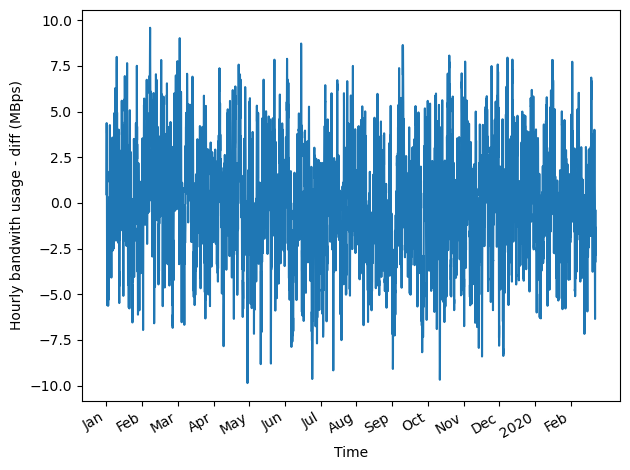

In [119]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)
fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

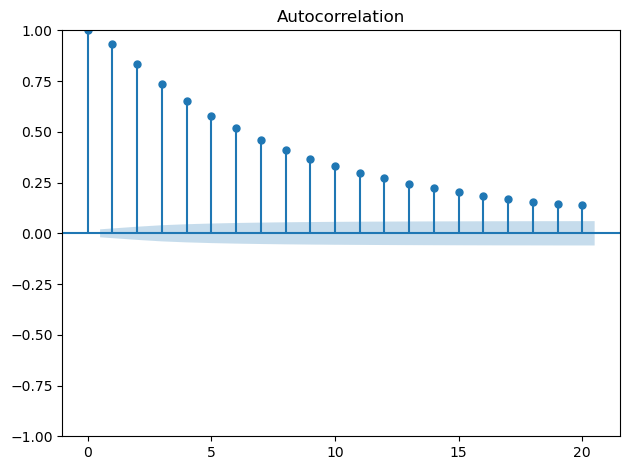

In [121]:
plot_acf(bandwidth_diff, lags=20);
plt.tight_layout()

plot_pacf(bandwidth_diff, lags=20);
plt.tight_layout()

9831
168


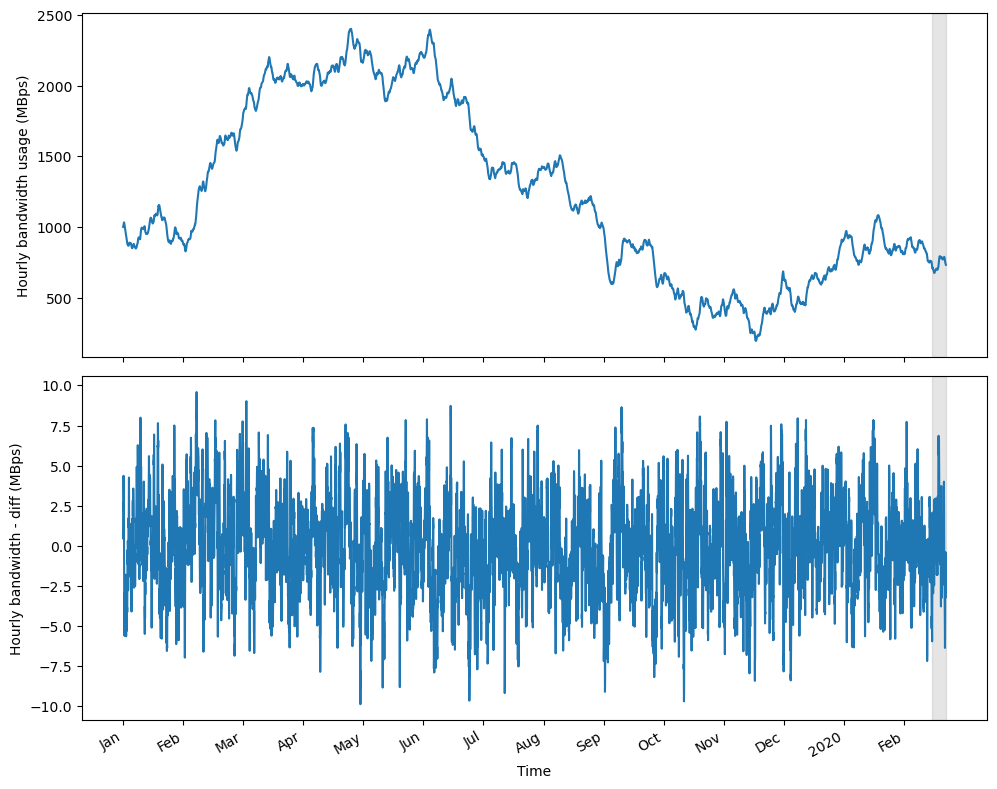

In [122]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [123]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/2260433852.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/Users/mickaelwajnberg/.conda/envs/time_series/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mickaelwajnberg/.conda/envs/time_series/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mickaelwajnberg/.conda/envs/time_series/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


this time bes model is 3,2 but 2,3 and 2,2 are very close, so we can argue 22 is the best  

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Sun, 19 Nov 2023   AIC                          27991.604
Time:                        01:47:55   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

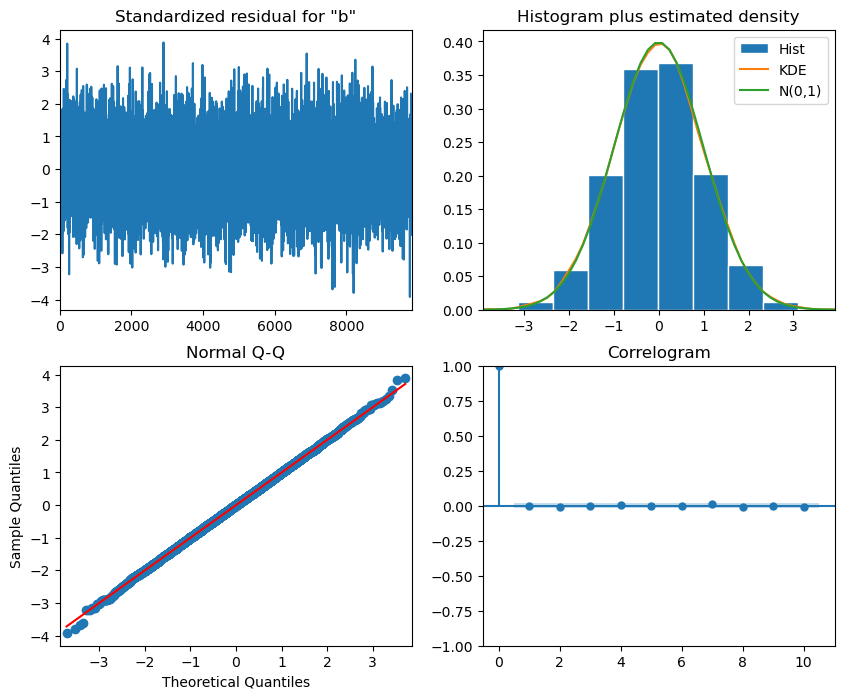

In [126]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10, 8));

In [127]:
residuals = model_fit.resid
lbres = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(lbres)

     lb_stat  lb_pvalue
1   0.042190   0.837257
2   0.418364   0.811247
3   0.520271   0.914416
4   0.850554   0.931545
5   0.850841   0.973678
6   1.111754   0.981019
7   2.124864   0.952607
8   3.230558   0.919067
9   3.248662   0.953615
10  3.588289   0.964015


In [128]:
def rolling_forecast3(_df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        _pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(_df[:i].values)
            _pred_mean.extend(mean for _ in range(window))
            
        return _pred_mean

    elif method == 'last':
        _pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = _df[:i].iloc[-1].values[0]
            _pred_last_value.extend(last_value for _ in range(window))
            
        return _pred_last_value
    
    elif method == 'ARMA':
        _pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            _model = SARIMAX(_df[:i], order=(2,0,2))
            res = _model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            _pred_ARMA.extend(oos_pred)
            
        return _pred_ARMA

In [129]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast3(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast3(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast3(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/1228515196.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/1228515196.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/1228515196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


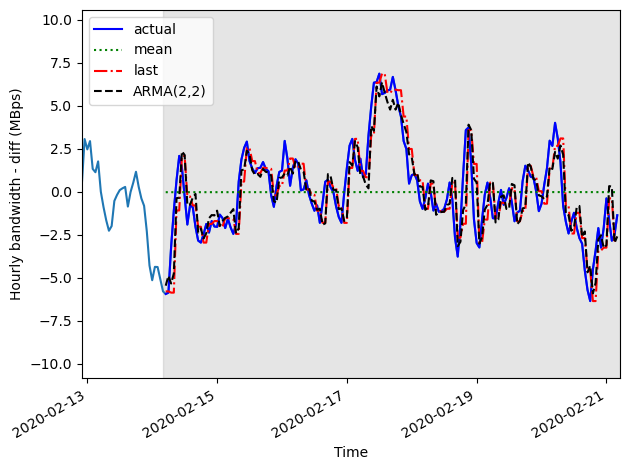

In [130]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

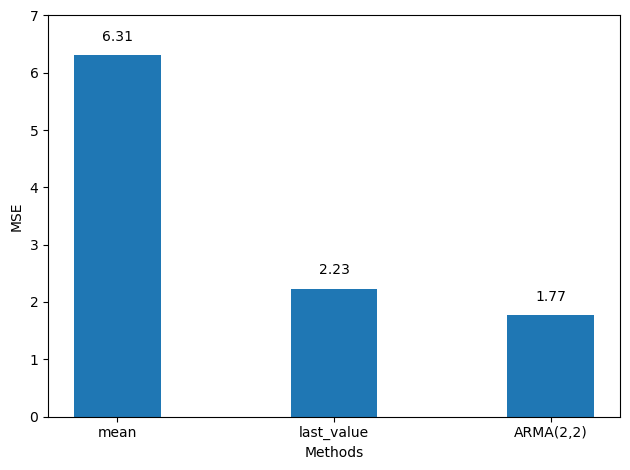

In [131]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

/var/folders/23/rr9tkydj3fj1lgvrw9qzlqqh0000gn/T/ipykernel_54909/110431770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()


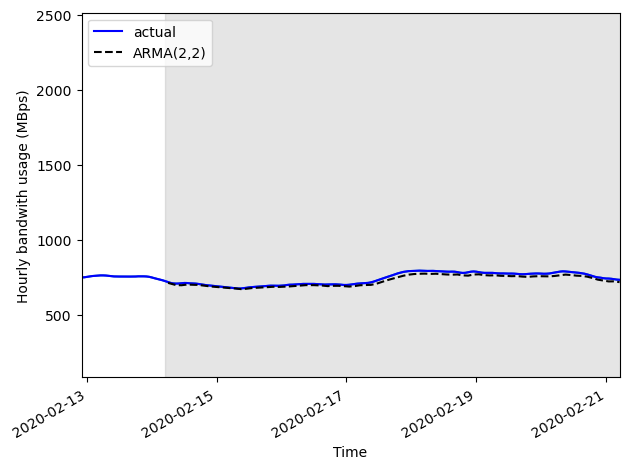

In [132]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [133]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362774419292
